# Centroid based Tracking
The idea for this tracking method is to track a specific object using the centroid of the objects detected in a frame, and comparing them with the ones detected in the previous frame.
- **Step #1**: Accept bounding box coordinates and compute centroids
- **Step #2**: Compute Euclidean distance between new bounding boxes and existing objects
- **Step #3**: Update (x, y)-coordinates of existing objects
---

The first thing we are going to test is to extract the objects of a frame based on the countours.

The steps to follow are the ones bellow:
1. Convert image to HSV
2. Threshold on red to segment the rectangle
3. Apply some morphology to close the contour as much as possible
4. Detect external contours
5. Filter noisy blobs based on area; You are looking for the largest contour
6. Get the contour's bounding rectangle
7. Slice the image using the bounding rectangle

In [2]:
def getCroppedBB(img, bb):
    img = img[bb[1]:bb[1]+bb[3],bb[0]:bb[0]+bb[2]]
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

---

In [2]:
!pip install filterpy

     -------------------------------------- 178.0/178.0 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110542 sha256=95bf608093fe6efa5802966657d26da868abbf425703582708fcea0965e9c757
  Stored in directory: c:\users\ivans\appdata\local\pip\cache\wheels\a4\80\24\0867e958c9459ae8d648d1adf89de38756d053debb1c9218d9
Successfully built filterpy


In [3]:
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook
import cv2
import matplotlib.pyplot as plt
import os
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import sys
import time
import AuxFunctions

In [4]:
def computeCentroid(box):
    xCoord = box[0] + box[2]/2
    yCoord = box[1] + box[3]/2
    
    return (xCoord, yCoord)

In [5]:
def computeEuclideanDistance(p1,p2):
    vect = (p2[0] - p1[0], p2[1] - p1[1])
    return np.sqrt(vect[0]*vect[0] + vect[1]*vect[1])

In [12]:
def runTracker(mainDirectory = "./datasets/MotorcycleChase", maxFramesToShow = 1000, showEveryX=5):
    
    # get bounding boxes data
    filepathBB = os.path.join(mainDirectory, "groundtruth_rect.txt")
    try:
        bbs = AuxFunctions.getBoundingBoxes(filepathBB)
    except:
        print("Haven't been found the groundtruth_rect.txt file")
        
    # analyze the first frame
    imgPath = os.path.join(mainDirectory, "img")
    frame0path = os.path.join(imgPath, "00001.jpg")
    firstFrame = cv2.imread(frame0path)

    bb = bbs[1]
    bbArea = (bb[2])*(bb[3])
        # save previous frame's box and centroid
    previousCentroid = computeCentroid(bb)
    previousBox = bb
    
    #frames to show
    framesToShow = min(maxFramesToShow, len(os.listdir(imgPath)))
    
    i = 0
    numFrame = 0
    for filename in os.listdir(imgPath)[2:framesToShow]:
        numFrame +=1
        # reading the frame
        filepath = os.path.join(imgPath, filename)   
        frameRGB = plt.imread(filepath)
        frame = cv2.imread(filepath,  cv2.IMREAD_GRAYSCALE)
        
        # array for boxes detected in the frame
        frameBoxes = []
        
        # detect objects in the frame ---------------------------
            # binarize the frame
        thresh, result = cv2.threshold(frame, 0, 255, cv2.THRESH_OTSU)
        result = ~result
        
            # extract countours
        contours, hierarchy = cv2.findContours(image=result, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
        ctrs = frame.copy()
        cv2.drawContours(image=ctrs, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
        
            # detect objects
        for _,c in enumerate(contours):
            blobArea = cv2.contourArea(c)
            if blobArea > bbArea*0.5 and blobArea < bbArea*1.5:
                boundingRect = cv2.boundingRect(c)

                offset = 2
                # Draw the rectangle on the input image
                # Get the dimensions of the bounding rect:
                rectX = int(boundingRect[0] + offset)
                rectY = int(boundingRect[1] + offset)
                rectWidth = int(boundingRect[2] - 2 * offset)
                rectHeight = int(boundingRect[3] - 2 * offset)

                color = (255, 0, 0)
                
                frameBoxes.append((int(rectX), int(rectY), int(rectX + rectWidth), int(rectY + rectHeight)))
        
        # find the centroid with minimum euclidean distance, if some has been detected
        if len(frameBoxes) != 0:
            idx = -1
            it = 0
            minDistance = float("inf")
            for box in frameBoxes:
                centroid_i = computeCentroid(box)
                tmpDist = computeEuclideanDistance(previousCentroid, centroid_i)
                if tmpDist < minDistance:
                    minDistance = tmpDist
                    idx = it
                it += 1
                
                # update new centroid
            previousBox = frameBoxes[idx]
            previousCentroid = computeCentroid(previousBox)
            bbArea = (previousBox[0]-previousBox[2])*(previousBox[1]-previousBox[3])
            
                # draw centroid
            color = (255, 0, 0)
            cv2.rectangle(frameRGB, (previousBox[0], previousBox[1]),(previousBox[2], previousBox[3]), color, 2) 

        fig,ax = plt.subplots()
        ax.imshow(frameRGB)
        plt.show() 
        
            


In [10]:
def runTrackerTest(mainDirectory = "./datasets/MotorcycleChase", maxFramesToShow = 1000, showEveryX=5):
    
    # get bounding boxes data
    filepathBB = os.path.join(mainDirectory, "groundtruth_rect.txt")
    try:
        bbs = AuxFunctions.getBoundingBoxes(filepathBB)
    except:
        print("Haven't been found the groundtruth_rect.txt file")
        
    # analyze the first frame
    imgPath = os.path.join(mainDirectory, "img")
    frame0path = os.path.join(imgPath, "00001.jpg")
    firstFrame = cv2.imread(frame0path)
    
    bb = bbs[1]
    bbArea = (bb[2])*(bb[3])
        # save previous frame's box and centroid
    previousCentroid = computeCentroid(bb)
    previousBox = bb
    
    #frames to show
    framesToShow = min(maxFramesToShow, len(os.listdir(imgPath)))
    
    i = 0
    numFrame = 0
    for filename in os.listdir(imgPath)[2:framesToShow]:
        numFrame +=1
        # reading the frame
        filepath = os.path.join(imgPath, filename)   
        frameRGB = plt.imread(filepath)
        frame = cv2.imread(filepath,  cv2.IMREAD_GRAYSCALE)
        
        # array for boxes detected in the frame
        frameBoxes = []
        
        # detect objects in the frame ---------------------------
            # binarize the frame
        thresh, result = cv2.threshold(frame, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        result = ~result
        
            # extract countours
        contours, hierarchy = cv2.findContours(image=result, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
        ctrs = frame.copy()
        cv2.drawContours(image=ctrs, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
        
            # detect objects
        for _,c in enumerate(contours):
            blobArea = cv2.contourArea(c)
            if blobArea > bbArea*0.1 and blobArea < bbArea*1.9:
                boundingRect = cv2.boundingRect(c)

                offset = 2
                # Draw the rectangle on the input image
                # Get the dimensions of the bounding rect:
                rectX = int(boundingRect[0] + offset)
                rectY = int(boundingRect[1] + offset)
                rectWidth = int(boundingRect[2] - 2 * offset)
                rectHeight = int(boundingRect[3] - 2 * offset)
                frameBoxes.append((int(rectX), int(rectY), int(rectX + rectWidth), int(rectY + rectHeight)))
    
        # find the centroid with minimum euclidean distance, if some has been detected
        if len(frameBoxes) != 0:
            idx = -1
            it = 0
            
            minDistance = float("inf")
            
            for box in frameBoxes:
                centroid_i = computeCentroid(box)
                tmpDist = computeEuclideanDistance(previousCentroid, centroid_i)
                if tmpDist < minDistance:
                    minDistance = tmpDist
                    idx = it
                it += 1
                
                # update new centroid
            previousBox = frameBoxes[idx]
            previousCentroid = computeCentroid(previousBox)
            bbArea = (previousBox[2] - previousBox[0])*(previousBox[3]-previousBox[1])
            print(previousBox)
            
                # draw centroid
            color = (255, 0, 0)
            cv2.rectangle(frameRGB, (previousBox[0], previousBox[1]),(previousBox[2], previousBox[3]), color, 2) 
        
        fig,ax = plt.subplots()
        ax.imshow(frameRGB)
        plt.show() 

(471, 207, 824, 351)


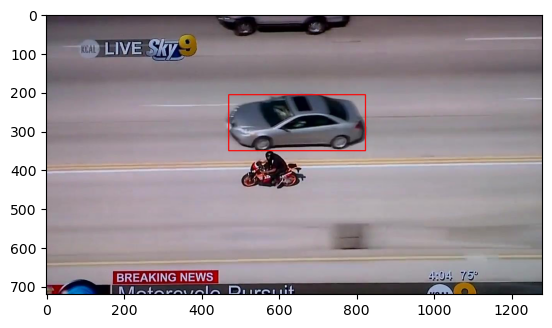

(485, 210, 838, 449)


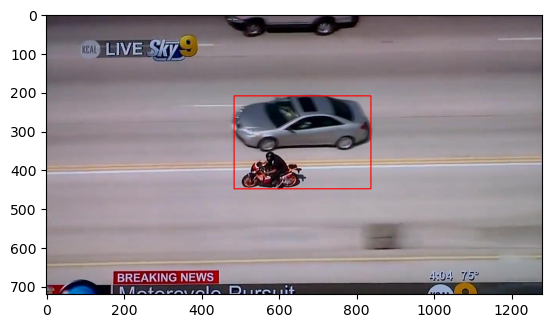

(498, 210, 852, 449)


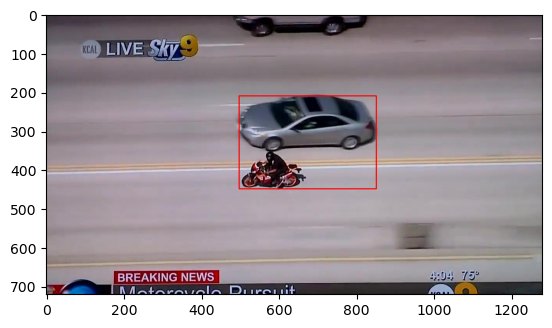

(507, 210, 865, 451)


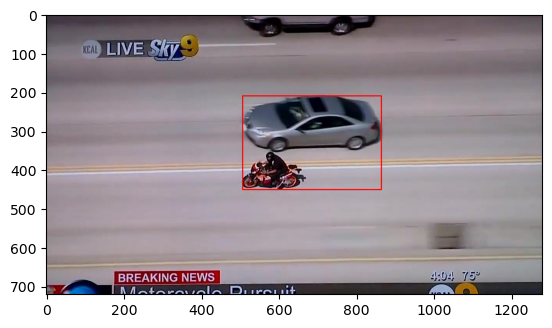

(522, 212, 877, 355)


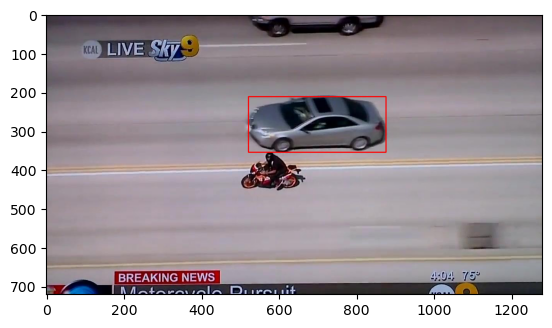

(534, 212, 888, 356)


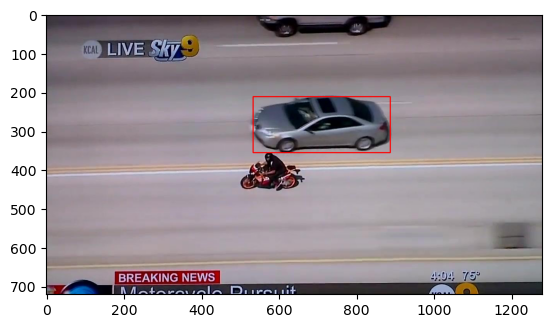

(547, 213, 900, 356)


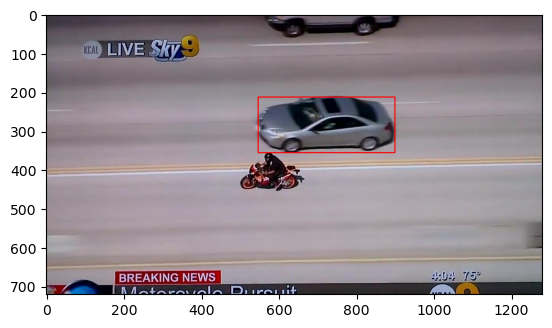

(558, 212, 914, 355)


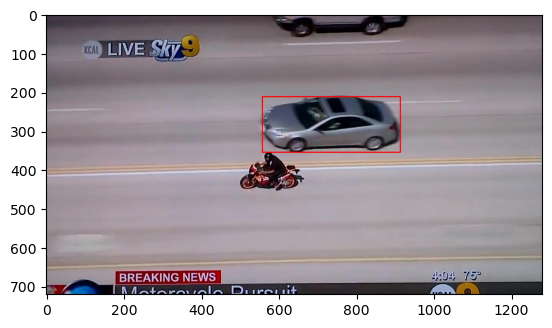

(572, 210, 927, 354)


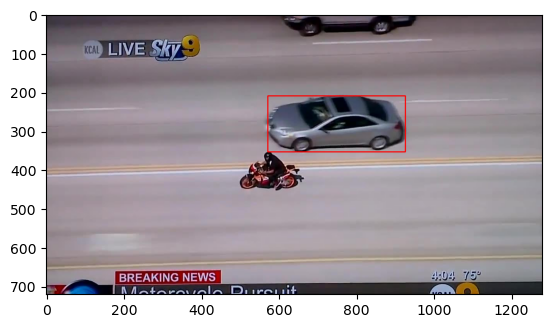

(584, 210, 939, 353)


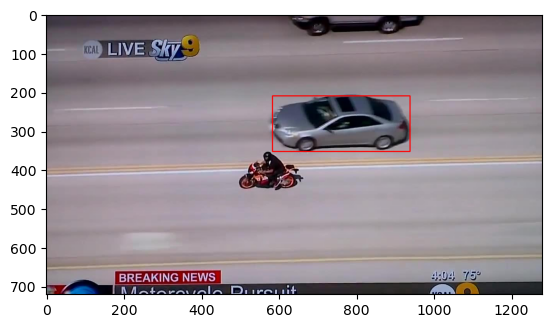

(597, 209, 952, 352)


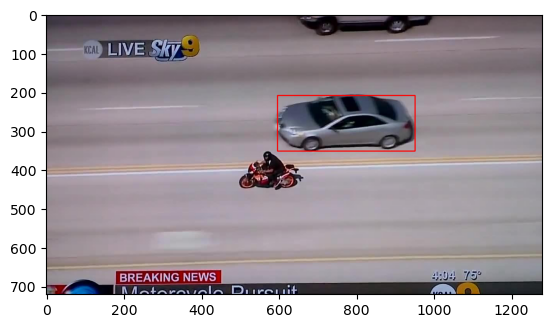

(610, 206, 966, 350)


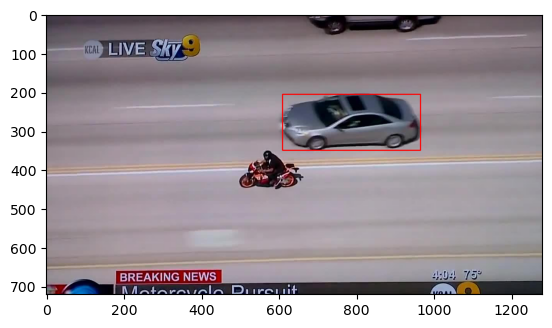

(623, 203, 979, 348)


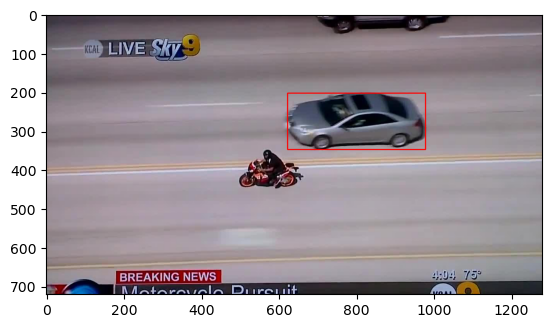

(637, 202, 994, 346)


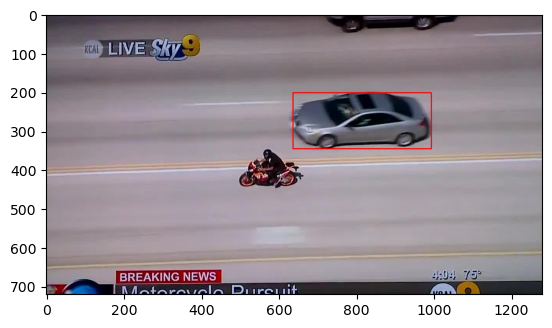

(650, 200, 1006, 344)


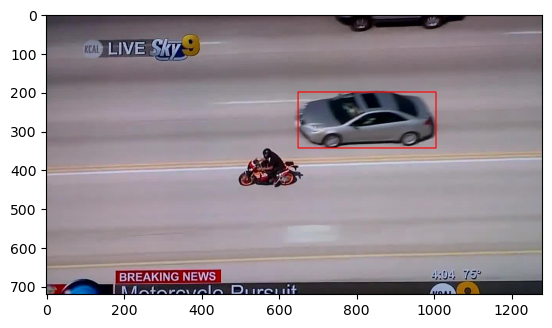

(662, 197, 1018, 341)


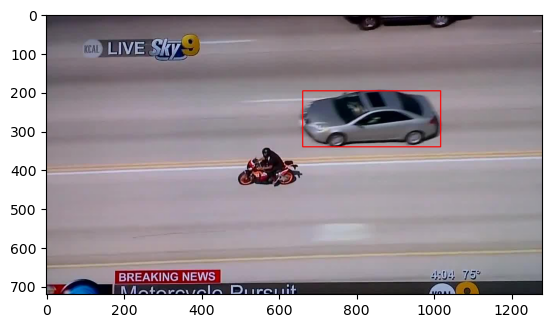

(673, 194, 1029, 339)


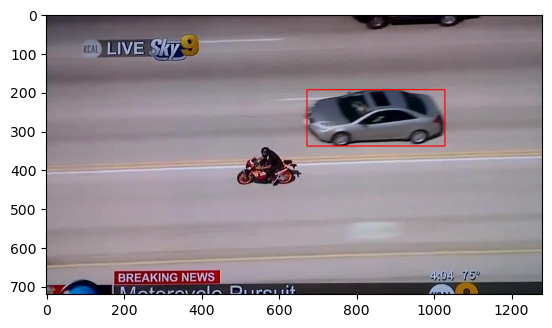

(686, 195, 1044, 338)


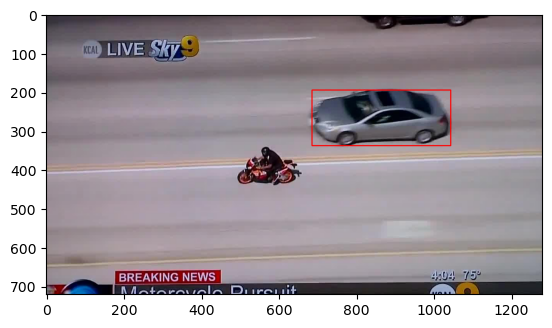

(699, 190, 1056, 334)


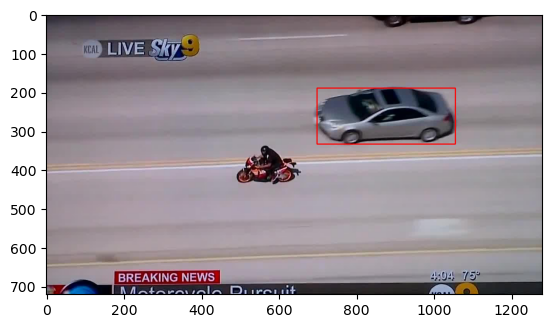

(711, 188, 1069, 333)


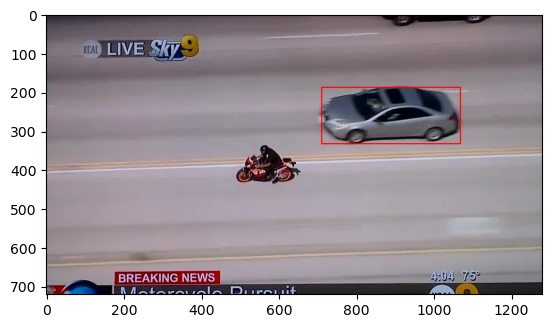

(724, 186, 1084, 331)


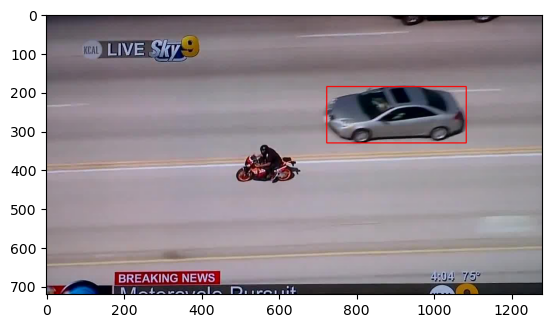

(738, 184, 1098, 330)


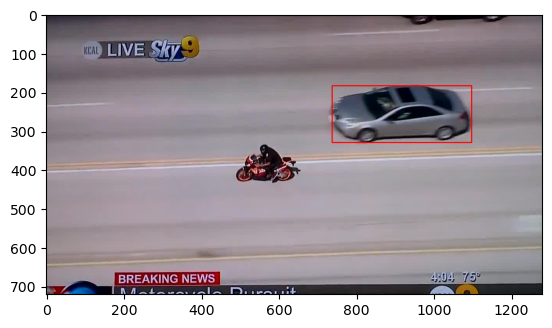

(752, 183, 1114, 329)


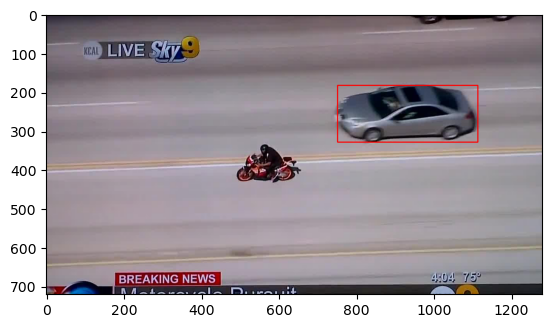

(768, 181, 1131, 327)


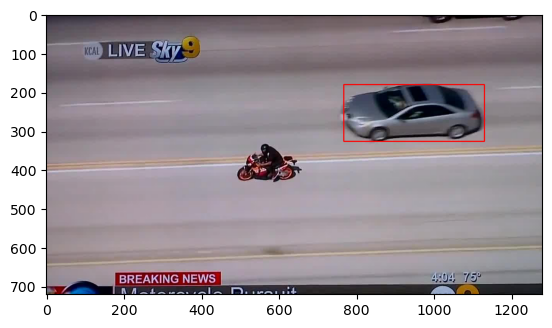

(782, 180, 1145, 326)


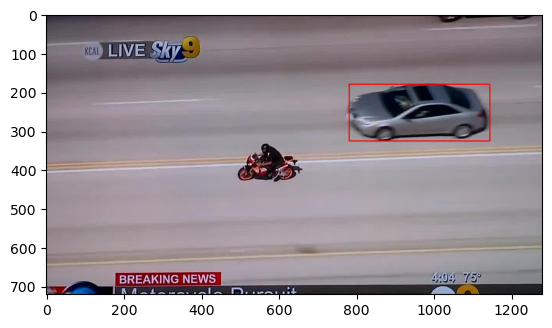

(797, 179, 1162, 325)


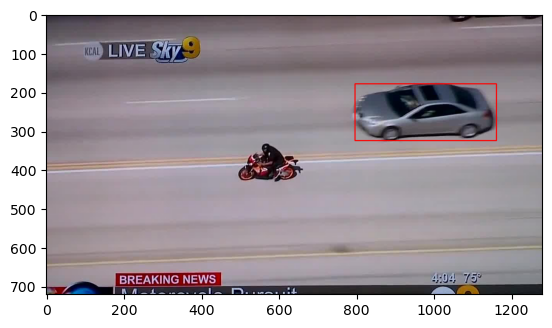

(813, 178, 1178, 324)


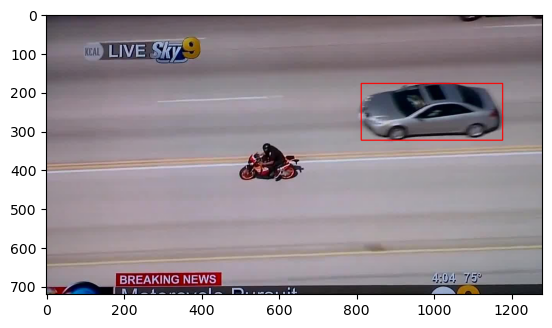

(829, 177, 1194, 323)


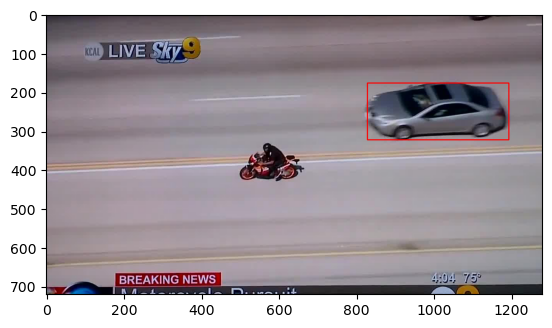

(842, 176, 1210, 322)


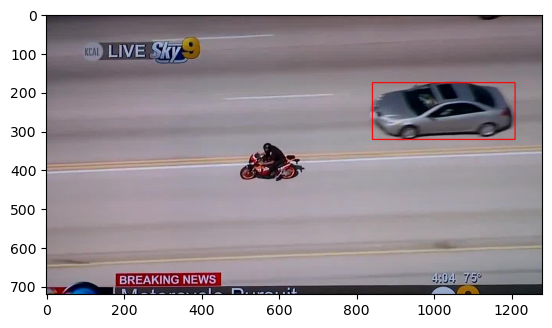

(858, 173, 1226, 320)


KeyboardInterrupt: 

In [14]:
runTrackerTest()

(581.0, 397.5)


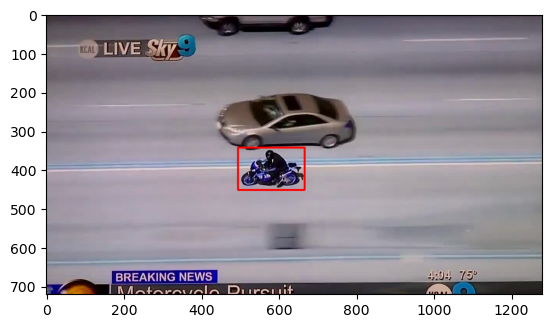

In [12]:
mainDirectory = "./datasets/MotorcycleChase"
maxFramesToShow = 1000
showEveryX=5
    
# get bounding boxes data
filepathBB = os.path.join(mainDirectory, "groundtruth_rect.txt")
try:
    bbs = AuxFunctions.getBoundingBoxes(filepathBB)
except:
    print("Haven't been found the groundtruth_rect.txt file")

# analyze the first frame
imgPath = os.path.join(mainDirectory, "img")
frame0path = os.path.join(imgPath, "00001.jpg")
firstFrame = cv2.imread(frame0path)

bbs = AuxFunctions.getBoundingBoxes()
bb = bbs[1]
bbArea = (bb[2])*(bb[3])

    # save previous frame's box and centroid
previousCentroid = computeCentroid(bb)
previousBox = bb
print(previousCentroid)

firstFrameCopy = firstFrame.copy()
cv2.rectangle(firstFrameCopy, (bb[0],bb[1]), (bb[0]+bb[2],bb[1]+bb[3]), (255,0,0), 3)
plt.imshow(firstFrameCopy)


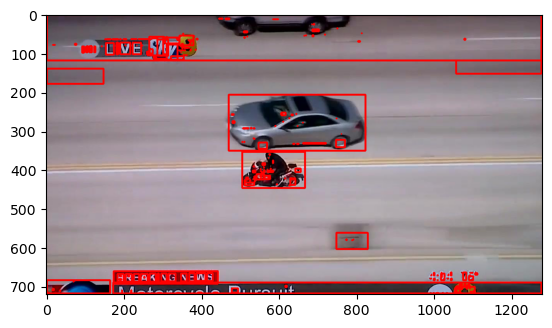

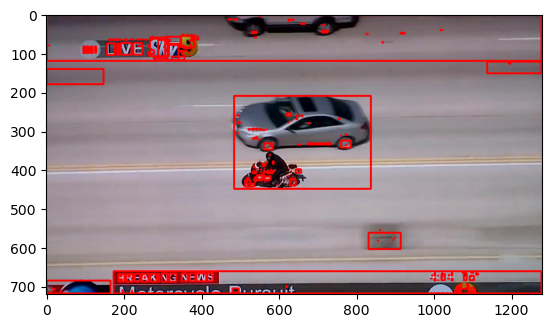

KeyboardInterrupt: 

In [35]:
#frames to show
framesToShow = min(maxFramesToShow, len(os.listdir(imgPath)))

i = 0
numFrame = 0
for filename in os.listdir(imgPath)[2:framesToShow]:
    numFrame +=1
    # reading the frame
    filepath = os.path.join(imgPath, filename)   
    frameRGB = plt.imread(filepath)
    frame = cv2.imread(filepath,  cv2.IMREAD_GRAYSCALE)

    # array for boxes detected in the frame
    frameBoxes = []

    # detect objects in the frame ---------------------------
        # binarize the frame
    thresh, result = cv2.threshold(frame, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    result = ~result

        # extract countours
    contours, hierarchy = cv2.findContours(image=result, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    ctrs = frame.copy()
    cv2.drawContours(image=ctrs, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)

        # detect objects
    for _,c in enumerate(contours):
        blobArea = cv2.contourArea(c)
        #if blobArea > bbArea*0.6 and blobArea < bbArea*1.4:
        boundingRect = cv2.boundingRect(c)

        offset = 2
        # Draw the rectangle on the input image
        # Get the dimensions of the bounding rect:
        rectX = int(boundingRect[0] + offset)
        rectY = int(boundingRect[1] + offset)
        rectWidth = int(boundingRect[2] - 2 * offset)
        rectHeight = int(boundingRect[3] - 2 * offset)

        blobBB = (rectX, rectY, rectWidth, rectHeight)

        # Box format: rectX, rectY, rectWidth, rectHeight
        #frameBoxes.append((blobBB[0], blobBB[1], blobBB[2], blobBB[3]))
        cv2.rectangle(frameRGB, (blobBB[0], blobBB[1]), (blobBB[0]+blobBB[2], blobBB[1]+blobBB[3]), (255,0,0), 3)
    
#     # find the centroid with minimum euclidean distance, if some has been detected
#     if len(frameBoxes) != 0:
#         idx = -1
#         it = 0

#         minDistance = float("inf")

#         for box in frameBoxes:
#             centroid_i = computeCentroid(box)
#             tmpDist = computeEuclideanDistance(previousCentroid, centroid_i)
#             if tmpDist < minDistance:
#                 minDistance = tmpDist
#                 idx = it
#             it += 1

#             # update new centroid
#         previousBox = frameBoxes[idx]
#         previousCentroid = computeCentroid(previousBox)
#         bbArea = (previousBox[2])*(previousBox[3])
#         print("Using last frame")
        
    # cv2.rectangle(frameRGB, (previousBox[0], previousBox[1]), (previousBox[0]+previousBox[2], previousBox[1]+previousBox[3]), (255,0,0), 3)
    fig,ax = plt.subplots()
    ax.imshow(frameRGB)
    plt.show() 

---

## Object detection based on Canny

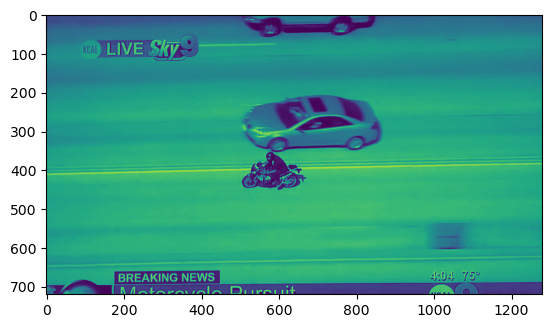

In [14]:
# STEP 1: image read
filepath = "./datasets/MotorcycleChase"
imgPath = os.path.join(filepath, "img")
file = os.path.join(imgPath, "00006.jpg")
frame = cv2.imread(file)

# convert from BGR to RGB
frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
plt.imshow(gray)

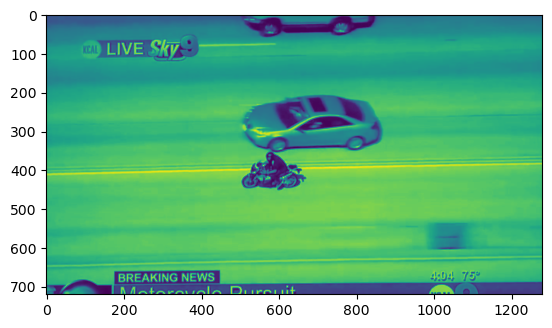

In [16]:
# STEP 2: Gaussian Blur for noise reduction
blurred = cv2.GaussianBlur(gray, (5,5), 0)
plt.imshow(blurred)

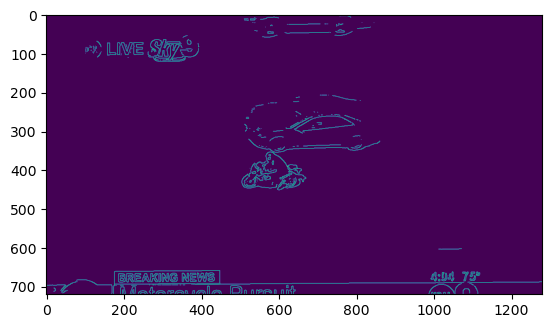

In [17]:
# STEP 3: Canny edge detection
edged = cv2.Canny(blurred, 200, 200)
    # morphological transformation in order to achieve better edge detection
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
dilate = cv2.dilate(edged, kernel, iterations=1)
plt.imshow(edged)


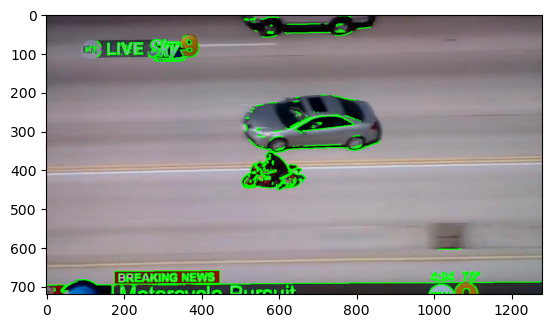

In [18]:
# STEP 4: Countour detection
contours, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
frame_copy = frame.copy()

# draw countours on the original image
cv2.drawContours(frame_copy, contours, -1, (0, 255, 0), 2)
plt.imshow(frame_copy)

(495, 343, 172, 109)
18748


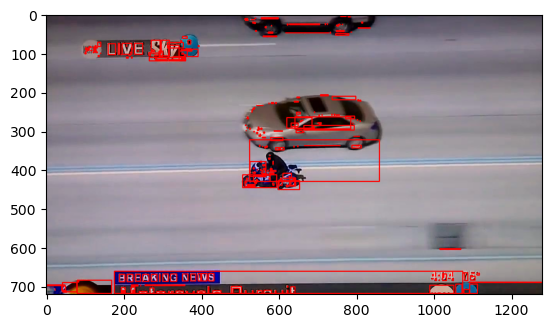

In [65]:
# draw boxes of detected countours
frame_copy = frame.copy()
    # first compute the first BB
mainDirectory = "./datasets/MotorcycleChase"
# get bounding boxes data
filepathBB = os.path.join(mainDirectory, "groundtruth_rect.txt")
try:
    bbs = AuxFunctions.getBoundingBoxes(filepathBB)
except:
    print("Haven't been found the groundtruth_rect.txt file")
    
    # analyze the first frame
imgPath = os.path.join(mainDirectory, "img")
frame0path = os.path.join(imgPath, "00001.jpg")
firstFrame = cv2.imread(frame0path)

bbs = AuxFunctions.getBoundingBoxes()
bb = bbs[1]
print(bb)
bbArea = (bb[2])*(bb[3])
print(bbArea)

cv2.rectangle(firstFrame, (bb[0],bb[1]), (bb[0]+bb[2], bb[1]+bb[3]), (255,0,0), 2)
plt.imshow(firstFrame)

    # draw all boxes similar to the first
for _,c in enumerate(contours):
    blobArea = cv2.contourArea(c)
    #if blobArea > bbArea*0.1 and blobArea < bbArea*1.9:
    boundingRect = cv2.boundingRect(c)

    offset = 2
    # Draw the rectangle on the input image
    # Get the dimensions of the bounding rect:
    rectX = int(boundingRect[0] + offset)
    rectY = int(boundingRect[1] + offset)
    rectWidth = int(boundingRect[2] - 2 * offset)
    rectHeight = int(boundingRect[3] - 2 * offset)

    color = (255, 0, 0)

    cv2.rectangle(frame_copy, (int(rectX), int(rectY)), (int(rectX + rectWidth), int(rectY + rectHeight)), (255,0,0), 2)

plt.imshow(frame_copy)
    

---


## K-means based object detection

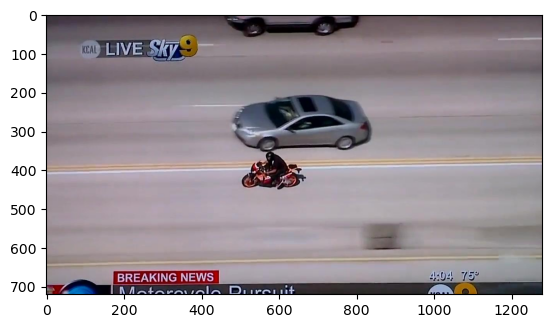

In [154]:
# STEP 1: image read
filepath = "./datasets/MotorCycleChase"
imgPath = os.path.join(filepath, "img")
file = os.path.join(imgPath, "00004.jpg")
frame = cv2.imread(file)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

plt.imshow(frame)

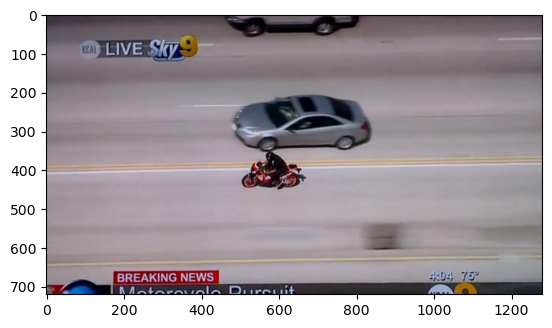

In [193]:
# STEP 2: Gaussian Blur for noise reduction
blurred = cv2.GaussianBlur(frame, (5,5), 0)
blurredGray = cv2.GaussianBlur(gray, (9,9),0)
plt.imshow(blurred)

In [194]:
# STEP 3: REshape image into 2d values
pixel_vals = blurred.reshape((blurred.shape[0]*blurred.shape[1],3))
pixel_vals = np.float32(pixel_vals)

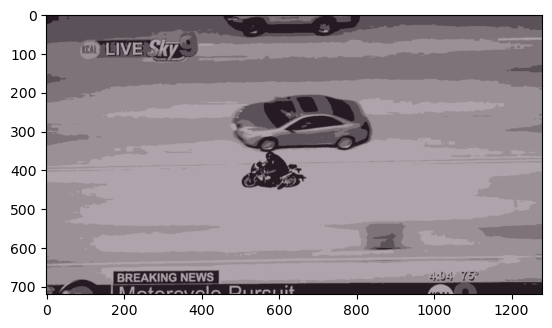

In [195]:
# STEP 4: K-means clustering
    # iteration termination criteria. When this criteria is satisfied, algorithm iteration stops
    # stop the algorithm iteration if specified accuracy, epsilon, is reached , or the specified number of iterations ir reached, max_iter
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

k = 5
retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]

segmented_image = segmented_data.reshape((blurred.shape))
labels_reshape = labels.reshape(frame.shape[0], blurred.shape[1])

plt.imshow(segmented_image)

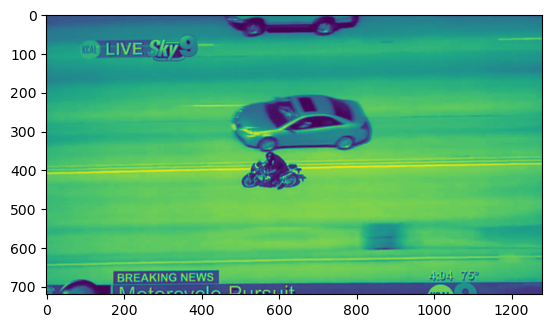

In [196]:
# STEP 6:  Convert to Gray
gray = cv2.cvtColor(blurred, cv2.COLOR_RGB2GRAY)
plt.imshow(gray)

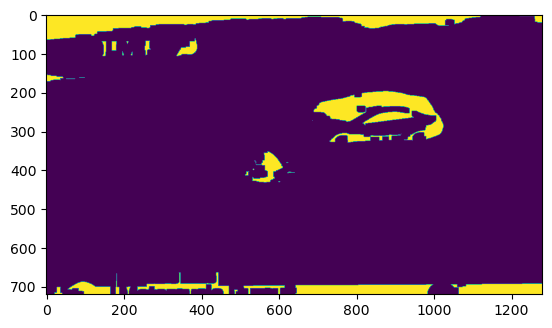

In [208]:
# STEP 7: Binarize
thresh, result = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
result = ~result
kernel = np.ones((10,10), np.uint8)
# Using cv2.erode() method 
result = cv2.erode(result, kernel) 

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13,13))
result = cv2.morphologyEx(result, cv2.MORPH_CLOSE, kernel)

plt.imshow(result)



In [200]:
    # extract countours
contours, hierarchy = cv2.findContours(image=result, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
ctrs = frame.copy()
cv2.drawContours(image=ctrs, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)



array([[[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [ 24, 174,  26],
        ...,
        [ 34, 174,  36],
        [  0, 255,   0],
        [  0, 255,   0]],

       ...,

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [ 15, 157,  25],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

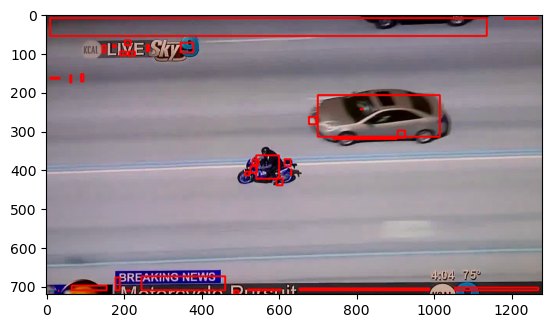

In [209]:
frameCopy = frame.copy()
    # detect objects
for _,c in enumerate(contours):
    blobArea = cv2.contourArea(c)
    #if blobArea > bbArea*0.6 and blobArea < bbArea*1.4:
    boundingRect = cv2.boundingRect(c)

    offset = 10
    # Draw the rectangle on the input image
    # Get the dimensions of the bounding rect:
    rectX = int(boundingRect[0] + offset)
    rectY = int(boundingRect[1] + offset)
    rectWidth = int(boundingRect[2] - 2 * offset)
    rectHeight = int(boundingRect[3] - 2 * offset)

    blobBB = (rectX, rectY, rectWidth, rectHeight)

    # Box format: rectX, rectY, rectWidth, rectHeight
    #frameBoxes.append((blobBB[0], blobBB[1], blobBB[2], blobBB[3]))
    cv2.rectangle(frameCopy, (blobBB[0], blobBB[1]), (blobBB[0]+blobBB[2], blobBB[1]+blobBB[3]), (255,0,0), 3)
    
plt.imshow(frameCopy)

#### Tracking for the whole video using Kmeans

(581.0, 397.5)


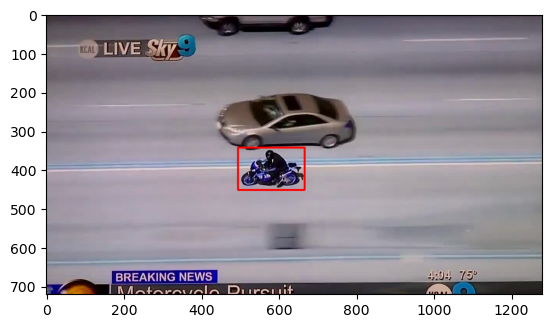

In [20]:
mainDirectory = "./datasets/MotorcycleChase"
maxFramesToShow = 1000
showEveryX=25
    
# get bounding boxes data
filepathBB = os.path.join(mainDirectory, "groundtruth_rect.txt")
try:
    bbs = AuxFunctions.getBoundingBoxes(filepathBB)
except:
    print("Haven't been found the groundtruth_rect.txt file")

# analyze the first frame
imgPath = os.path.join(mainDirectory, "img")
frame0path = os.path.join(imgPath, "00001.jpg")
firstFrame = cv2.imread(frame0path)

bb = bbs[1]
bbArea = (bb[2])*(bb[3])

    # save previous frame's box and centroid
previousCentroid = computeCentroid(bb)
previousBox = bb
print(previousCentroid)

firstFrameCopy = firstFrame.copy()
cv2.rectangle(firstFrameCopy, (bb[0],bb[1]), (bb[0]+bb[2],bb[1]+bb[3]), (255,0,0), 3)
plt.imshow(firstFrameCopy)


Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame


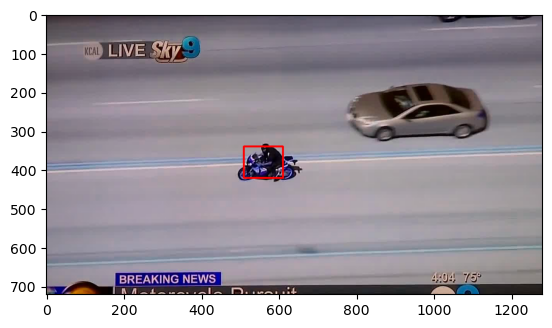

Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame


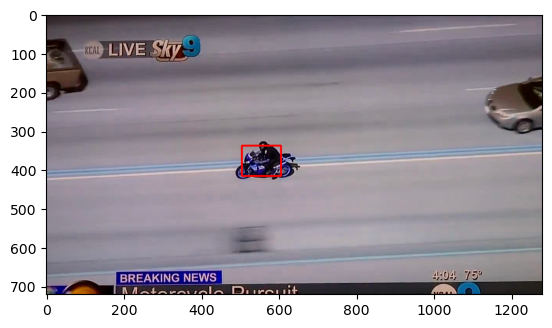

Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame


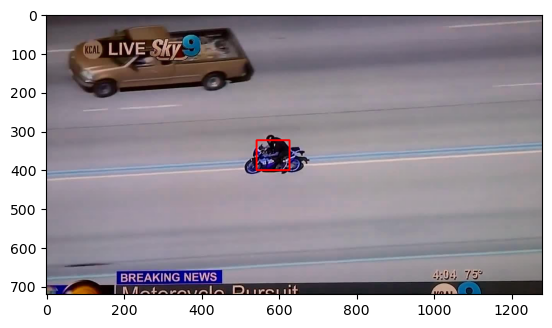

Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame


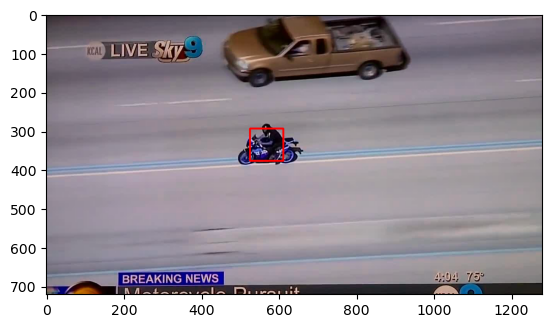

Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame


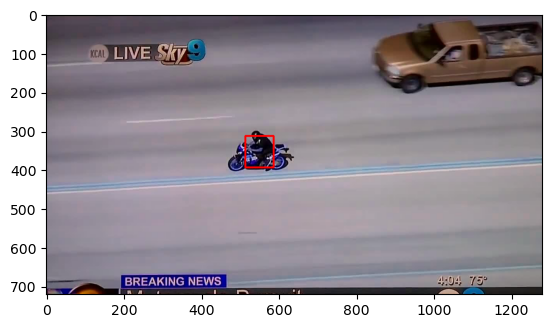

Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame


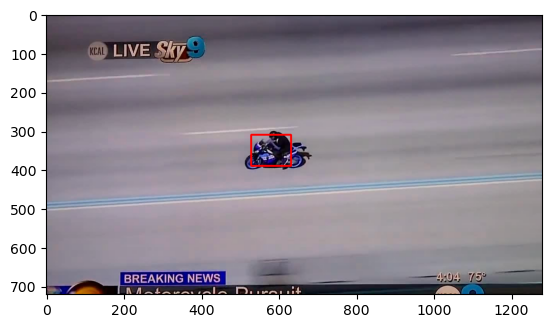

Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame


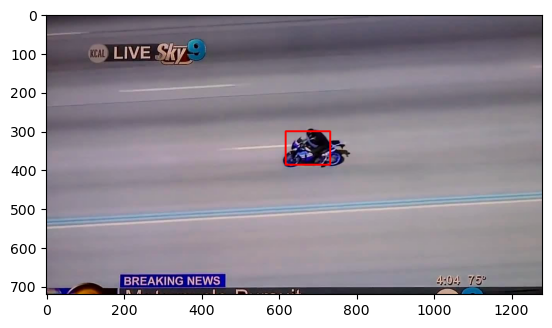

Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame


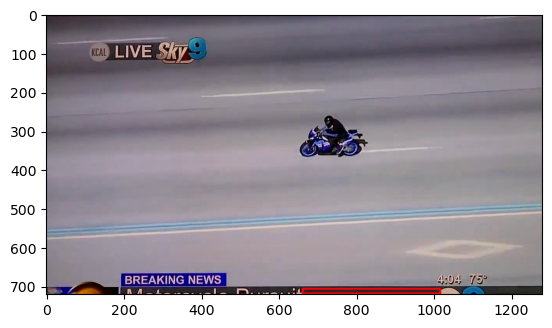

Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame


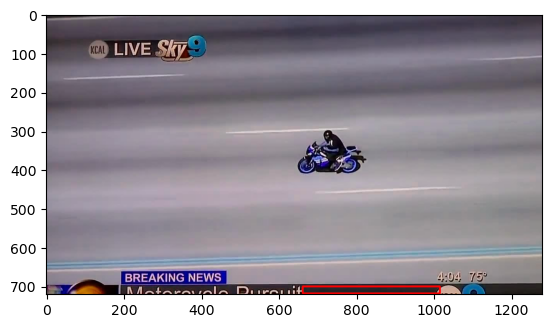

Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame
Using last frame


KeyboardInterrupt: 

In [21]:
#frames to show
framesToShow = min(maxFramesToShow, len(os.listdir(imgPath)))

i = 0
numFrame = 0
for filename in os.listdir(imgPath)[2:framesToShow]:
    numFrame +=1
    # reading the frame
    filepath = os.path.join(imgPath, filename)   
    frame = plt.imread(filepath)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # array for boxes detected in the frame
    frameBoxes = []

    # detect objects in the frame ---------------------------
    blurred = cv2.GaussianBlur(frame, (5,5), 0)
    
    pixel_vals = blurred.reshape((blurred.shape[0]*blurred.shape[1],3))
    pixel_vals = np.float32(pixel_vals)
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

    k = 5
    retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    segmented_data = centers[labels.flatten()]

    segmented_image = segmented_data.reshape((blurred.shape))
    labels_reshape = labels.reshape(frame.shape[0], blurred.shape[1])
    
    gray = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2GRAY)
    
    thresh, result = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
    result = ~result
    kernel = np.ones((10,10), np.uint8)
    # Using cv2.erode() method 
    result = cv2.erode(result, kernel) 

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13,13))
    result = cv2.morphologyEx(result, cv2.MORPH_CLOSE, kernel)
    
        # extract countours
    contours, hierarchy = cv2.findContours(image=result, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    ctrs = frame.copy()
    cv2.drawContours(image=ctrs, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)

    frameRGB = frame.copy()
        # detect objects
    for _,c in enumerate(contours):
        blobArea = cv2.contourArea(c)
        if blobArea > bbArea*0.1 and blobArea < bbArea*1.9:
            boundingRect = cv2.boundingRect(c)

            offset = 2
            # Draw the rectangle on the input image
            # Get the dimensions of the bounding rect:
            rectX = int(boundingRect[0] + offset)
            rectY = int(boundingRect[1] + offset)
            rectWidth = int(boundingRect[2] - 2 * offset)
            rectHeight = int(boundingRect[3] - 2 * offset)

            blobBB = (rectX, rectY, rectWidth, rectHeight)

            # Box format: rectX, rectY, rectWidth, rectHeight
            frameBoxes.append((blobBB[0], blobBB[1], blobBB[2], blobBB[3]))
            #cv2.rectangle(frameRGB, (blobBB[0], blobBB[1]), (blobBB[0]+blobBB[2], blobBB[1]+blobBB[3]), (255,0,0), 3)
    
    # find the centroid with minimum euclidean distance, if some has been detected
    if len(frameBoxes) != 0:
        idx = -1
        it = 0

        minDistance = float("inf")

        for box in frameBoxes:
            centroid_i = computeCentroid(box)
            tmpDist = computeEuclideanDistance(previousCentroid, centroid_i)
            if tmpDist < minDistance:
                minDistance = tmpDist
                idx = it
            it += 1

            # update new centroid
        previousBox = frameBoxes[idx]
        previousCentroid = computeCentroid(previousBox)
        bbArea = (previousBox[2])*(previousBox[3])
        print("Using last frame")
        
        cv2.rectangle(frameRGB, (previousBox[0], previousBox[1]), (previousBox[0]+previousBox[2], previousBox[1]+previousBox[3]), (255,0,0), 3)
        
    # cv2.rectangle(frameRGB, (previousBox[0], previousBox[1]), (previousBox[0]+previousBox[2], previousBox[1]+previousBox[3]), (255,0,0), 3)
    if(numFrame%showEveryX == 0):
        fig,ax = plt.subplots()
        ax.imshow(frameRGB)
        plt.show() 